### Riddler Express
From Leonard Cohen comes a timely matter of touchdowns:

In the Riddler Football League, you are coaching the Arizona Ordinals against your opponent, the Detroit Lines, and your team is down by 14 points. You can assume that you have exactly two remaining possessions (i.e., opportunities to score), and that Detroit will score no more points.

For those unfamiliar with American football, a touchdown is worth 6 points. After each touchdown, you can decide whether to go for 1 extra point or 2 extra points. You happen to have a great kicker on your team, and your chances of scoring 1 extra point (should you go for it) are 100 percent. Meanwhile, scoring 2 extra points is no sure thing — suppose that your team’s probability of success is some value p.

If the teams are tied at the end of regulation, the game proceeds to overtime, which you have a 50 percent chance of winning. (Assuming ties are not allowed.)

What is the minimum value of p such that you’d go for 2 extra points after your team’s first touchdown (i.e., when you’re down 8 points)?

### General Assumptions:

- Other team is up by 14 and won't score again
- `p = 0.5` of winning in overtime
- `p = 1` of making an extra point
- Since there is no discussion around winning if we don't score twice I will assume a state of the world where we score twice

### Analytical Solution

*Win if we stick to FGs*
- P(W) = 0.5 since we go to overtime

*Win if we try first two point can be split up into 2 WIN scenarios:*
- We convert on two point: `p`
- We miss first attempt, convert second attempt to go to overtime and win: `(1-p) * p * 0.5`

*Solve for `p` in the following*

$ 0.5 \lt p + (1-p)*p*0.5 $

$ 0.5 \lt \frac{3p}{2} - \frac{1p^{2}}{2}$

$ 1 \lt 3p - p^{2}$

$ p^{2} - 3p + 1 = 0$

`p` solutions are:
- 0.381966
- 2.6180339 (outside of 0-1 boundary so irrelevant)

Solution: `p > 0.38197`

### Now Computational Solution: 

Run simulations across a range of `p` values, first with an inefficient class approach.

In [1]:
import random
import numpy as np
import time

class gameSim():
    def __init__(self, p, n):
        self.p = p
        self.games = n
        self.wins = 0
        
    def singleGame(self):
        """Run a single game and return win as 1 loss as 0"""
        tmp_score = 0 # initialize score at 0
        attempt = 0
        
        # run sim in regulation
        while attempt < 2:
            attempt += 1

            # we attempt 2 if our score is < 8
            if tmp_score < 8:
                event = random.choices(population = [0,1], weights = [1-self.p, self.p], k = 1)
                if event[0] == 1:
                    tmp_score += 8
                else:
                    tmp_score += 6
            # otherwise we'd go for the sure thing
            else:
                tmp_score += 7

        # in reg is done -> did we win, lose or tie? 
        # tie -> equal chance of winning
        if tmp_score == 14:
            return random.choice([0,1])
        return int(tmp_score > 14)

    def runSim(self):
        """Run sim of games with static p"""
        for _ in range(self.games):
            self.wins += self.singleGame()
            
        return self.wins / self.games
    

In [2]:
# Build a range of probs for success in 2 point
start = time.time()
probs = np.linspace(0.3,0.5,1001) # limiting bounds due to inefficiency
i = 0
n = 100_000 # Note: Due to inefficiency limiting to 100K

# Iterate until we find a p that allows for win > 0.5
while True:
    p_sim = gameSim(probs[i],n)
    exp_win = p_sim.runSim()
    if exp_win > 0.5:
        print(f"With a p = {probs[i]:.5f} we should go for it!")
        print(f"Took {time.time() - start:.2f} seconds")
        break
    i += 1

With a p = 0.38160 we should go for it!
Took 84.01 seconds


### Speed up with Numpy

We can iterate same bounds much faster, allowing us to simulate `10X` games but still significantly drop the total time. 

#### Improve the below:

Even better would be to just build a single matrix where each row represents a different `p` value. Then vectorization can handle everything in a single pass through rather than needing to iterate. Will consider this a nice `TODO`

In [3]:
# Build a range of probs for success in 2 point
start = time.time()
probs = np.linspace(0.3,0.5,1001)
i = 0
n = 1_000_000 # searching over 1MM 

while True:
    # determine if successful initial 2pt conv
    p = probs[i]
    scores = np.random.choice([6,8], size=n, replace=True, p=[1-p,p])

    # split into each type: score > 7 is automatic win given p = 1 for FG
    wins = len(scores[scores > 7])

    # unsuccessful we have some work to do: 
    # All are 6, so we can either get a 14 to tie or a 12 to lose
    unsuccessful = scores[scores < 8]
    second_try = np.random.choice([12,14], size=len(unsuccessful), replace=True, p=[1-p,p])

    # we keep ties
    ties = second_try[second_try == 14]

    # determine successes for ties -> 50%, so just using default p
    ot_wins = np.sum(np.random.choice([0,1], size = len(ties)))

    win_prob = (ot_wins + wins) / n
    
    
    if win_prob > 0.5:
        print(f"With a p = {probs[i]:.5f} we should go for it!")
        print(f"Took {time.time() - start:.2f} seconds")
        break
        
    i += 1

With a p = 0.38180 we should go for it!
Took 21.22 seconds


### And totally unecessary, but let's plot it out: 

Expanding search over 0-1, keeping 1MM records

In [4]:
# Build a range of probs for success in 2 point
start = time.time()
probs = np.linspace(0,1,1001)
i = 0
n = 1_000_000 # searching over 1MM 
win_exp = []

for p in probs:
    scores = np.random.choice([6,8], size=n, replace=True, p=[1-p,p])
    wins = len(scores[scores > 7])
    unsuccessful = scores[scores < 8]
    second_try = np.random.choice([12,14], size=len(unsuccessful), replace=True, p=[1-p,p])
    ties = second_try[second_try == 14]
    ot_wins = np.sum(np.random.choice([0,1], size = len(ties)))
    win_prob = (ot_wins + wins) / n
    win_exp.append(win_prob)
    
print(f"Full search time: {time.time() - start:.3} seconds")

Full search time: 45.2 seconds


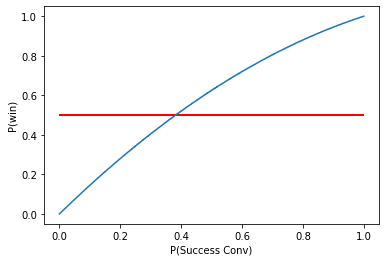

In [5]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(probs, win_exp)
ax.hlines(y=0.5, xmin=0, xmax=1, linewidth=2, color='r')
plt.xlabel("P(Success Conv)")
plt.ylabel("P(win)");